In [1]:
import numpy as np

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, EfficientNet_B7_Weights, efficientnet_b7
from torchvision.models import GoogLeNet_Weights, googlenet
from matplotlib.pyplot import imshow

import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/pruning'

Mounted at /content/drive


In [3]:
weights=EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)
model.eval()
device = torch.device('cuda:0')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [4]:
%cd /content/drive/MyDrive/pruning

/content/drive/MyDrive/pruning


0 : Siamese cat, Siamese (proba =  0.398)
1 : cougar, puma, catamount, mountain lion, painter, panther, Felis concolor (proba =  0.169)
2 : Egyptian cat (proba =  0.088)
3 : lynx, catamount (proba =  0.086)
4 : kit fox, Vulpes macrotis (proba =  0.015)


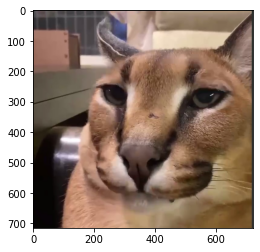

In [5]:
from imagenet1000_labels import labels
from torch.nn.functional import softmax
from PIL import Image


preprocess = weights.transforms()

im = Image.open(root + '/test_image.jpg')
imshow(im)

transformed = preprocess(im).unsqueeze(0)
ranks = model(transformed.cuda())[0]
proba = softmax(ranks, dim = -1)
best_ranks_idxs = ranks.argsort(descending = True)[:5]
for i, index in enumerate(best_ranks_idxs):
    print(f'{i} : {labels[index.item()]} (proba = {proba[index.item()] : .3f})')

In [6]:
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [8]:
import datasets

dataset = datasets.load_from_disk('data/validation_extracted.hf')

/usr/local/lib/python3.8/dist-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [54]:
from torchvision import transforms
t = transforms.ToTensor()

class MockLoader:
  def __init__(self, dataset, batch_size = 4):
    self.dataset = dataset
    self.batch_size = batch_size
    self.idx = 0
  
  def __iter__(self):
    return self

  def __next__(self):
    X_batch = []
    Y_batch = []
    for _ in range(self.batch_size):
      obj = self.dataset[self.idx]
      self.idx += 1
      if self.idx >= len(self.dataset):
        self.idx = 0
      try:
        X_batch.append(preprocess(obj['image']))
        Y_batch.append(obj['label'])
      except RuntimeError:
        pass
    return torch.stack(X_batch), torch.Tensor(Y_batch)

loader = MockLoader(dataset)

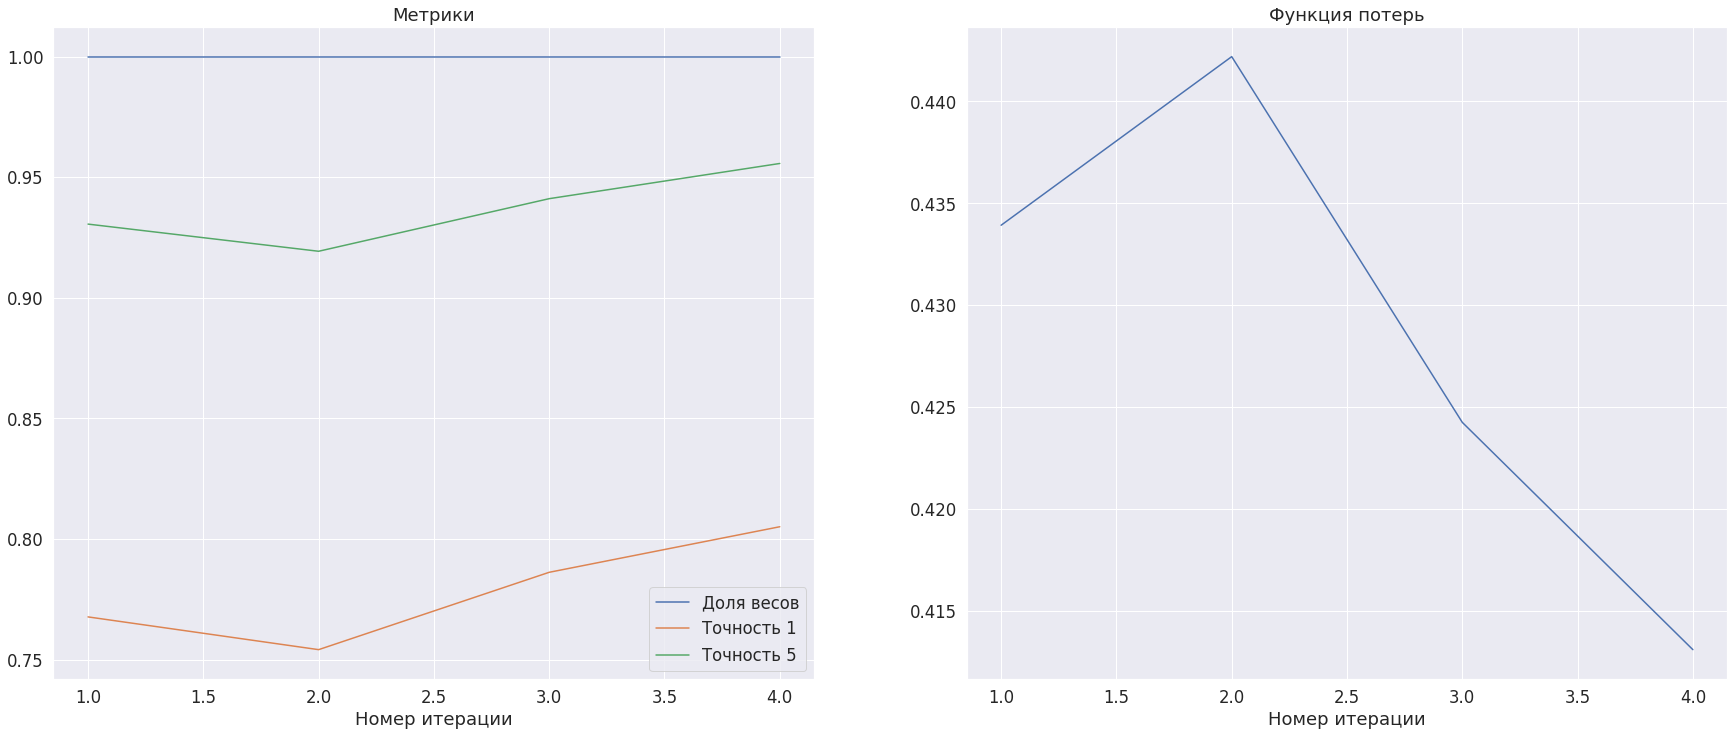

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
%load_ext autoreload
%autoreload 2

from utils import get_metrics
from genetic_algorithm import *

representation = CNNMaskPrune(model)
mutator = ConvGeneMutator(representation.fc_length, representation.conv_length,
                          0.15, 0.01)

l1, l2, l3 = 1, 1, 1
def fitness_func(metrics):
    weight_ratio, model_acc1, model_acc5 = metrics
    top1_errors = 1 - model_acc1
    top5_errors = 1 - model_acc5
    return (l1*weight_ratio + l2*top1_errors + l3*top5_errors) / (l1 + l2 + l3)

selector = FitnessSelector()
crossover = LossCrossover()


metrics = lambda model : get_metrics(model, loader, max_iter = 200)

mtl = MultiTargetLoss(representation, mutator, selector,
                      crossover, metrics, fitness_func)

сnn_pruned1 = mtl.prune()